# User report for a telecom company

The task is to analyze data for telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans is more profitable in order to adjust the advertising budget.
The task is to carry out a preliminary analysis of the plans based on a relatively small client selection. We have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. The job is to analyze clients' behavior and determine which prepaid plan is more profitable.

In [1]:
import pandas as pd
import numpy as np
#loading data
get_id = np.vectorize(lambda x: re.sub('.*_',  '' ,   x))

calls = pd.read_csv('/datasets/megaline_calls.csv')
calls['duration'] = calls['duration'].apply(np.ceil)
#calls.head()
#calls.info()
#calls.describe()
import re
get_id = np.vectorize(lambda x: re.sub('.*_',  '' ,   x))
def get_info_date(df):
    columns = df.columns.tolist()
    idx = [columns.index(x) for x in columns  if 'date' in x][0]
    
    df[columns[idx]] = pd.to_datetime(df[columns[idx]])
    df['day'] = df[columns[idx]].dt.day_name()
    df['month'] = df[columns[idx]].dt.month_name()
    df['year'] = df[columns[idx]].dt.year
    return df







In [2]:
internet = pd.read_csv('/datasets/megaline_internet.csv')
internet = get_info_date(internet)
internet['id'] = get_id(internet['id'])
#internet.info()
#internet.describe()


In [3]:
messages = pd.read_csv('/datasets/megaline_messages.csv')
messages['id'] = get_id(messages['id'])
messages = get_info_date(messages)

#messages.head()
#messages.info()
#messages.describe()

In [4]:
plans = pd.read_csv('/datasets/megaline_plans.csv')
#plans.head()
#plans.info()
#plans.describe()

In [5]:
users = pd.read_csv('/datasets/megaline_users.csv')
#users.head()
#users.info()
#users.columns
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
users.rename(columns = {'tariff':'plan'}, inplace = True)
cities = users[["user_id","city"]]



I initially loaded the data assuming there was a tab seperator, and that was not the case. That caused me to spend a lot of time wondering why my value_counts function wasn't working. I rounded up the call durations so that customers who had a remainder less than 1 minute on their calls would be charged for the whole minute. 

For data used, I first aggregated the total amount of data a customer used in a month, and then I rounded that up to the nearest thousand.


In [6]:
#calls_per_user = calls['user_id'].value_counts().rename_axis('user_id').reset_index(name='total_calls')
#print(calls_per_user.head())

calls['call_date'] = pd.to_datetime(calls['call_date'])
calls['id'] = get_id(calls['id'])
calls = get_info_date(calls)
#calls_per_month = pd.pivot_table(calls, index = 'user_id', columns='call_date',aggfunc='count')
calls_per_month = (calls.groupby(['user_id',
                                calls['call_date'].dt.month.rename('month')])['call_date']
                        .count()
                        .reset_index())
calls_per_month.columns = ['user_id','date','total_calls']
#print(calls_per_month.info())
#calls_per_month.head(10)


We have only 481 users. This makes sense because there are 500 users and it is reasonable to assume that 19 of them made no calls. One user made 1300 calls and one user made only 2 calls, this is a wide range, but again, not particularly extraordinary to cause concern. We then Aggregated the total number of calls each user made per month.

In [7]:
#minutes_per_month = calls.groupby(by='user_id').sum()
minutes_per_month = calls.groupby(['user_id',calls['call_date'].dt.month])['duration'].sum().reset_index()
#minutes_per_month.head(20)
#minutes_per_month.describe()


Again, we see 481 users, which is the number we expected. The mean amount of time that a user talks for in a month is 435 minutes, with one customer talking for as many as 1510 minutes in a month. This is about 25 hours, which is not enough to give us cause for suspicion with regards to our computation being correct..

In [8]:
messages['message_date'] = pd.to_datetime(messages['message_date'], errors='coerce')
messages_per_month = messages.groupby(['user_id',messages['message_date'].dt.month.rename('month')])['message_date'].count().reset_index()
messages_per_month.columns = ['user_id','date','total_messages']
#messages_per_month.head(10)
#messages_per_user.describe()



Each user sends an average of 42 messages per month. The range is reasonable too.

In [9]:
internet['session_date'] = pd.to_datetime(internet['session_date'], errors='coerce')
internet_per_month = (internet.groupby(['user_id', internet['session_date'].dt.month])['mb_used']
   .sum()
   .reset_index())
#internet_per_month.head(10)
#internet_per_month.info()
internet_per_month['mb_used'] = internet_per_month['mb_used']/1000
internet_per_month['mb_used'] = internet_per_month['mb_used'].apply(np.ceil)
internet_per_month['mb_used'] = internet_per_month['mb_used']*1000
#internet_per_month.head(10)

More people use the internet than the number of people who make calls. The range is reasonable 
and the mean is 78610 GB of data

In [10]:

#Calls per user per month
calls_made = calls.groupby(['user_id','month']).agg({'id':'count'}).rename(columns={'id':'calls'})

#Minutes per user per month
min_spent = calls.groupby(['user_id','month']).agg({'duration':'sum'}).rename(columns={'duration':'duration'})

#Traffic per user per month
mb_used = internet.groupby(['user_id','month']).agg({'mb_used':'sum'}).rename(columns={'mb_used':'mb_used'})

#Messages per user per month
messages_sent = messages.groupby(['user_id','month']).agg({'id':'count'}).rename(columns={'id':'total_messages'})

#Plan for each user
plan = users[['user_id','plan']]

user_attributes = pd.concat([calls_made, min_spent, mb_used, messages_sent],axis=1).merge(plan,on='user_id')

user_attributes.head()


,user_id,calls,duration,mb_used,total_messages,plan
0,1000,16.0,124.0,1901.47,11.0,ultimate
1,1001,27.0,182.0,6919.15,30.0,surf
2,1001,56.0,412.0,19369.18,44.0,surf
3,1001,64.0,426.0,18504.30,36.0,surf
4,1001,65.0,393.0,22330.49,53.0,surf


In [11]:
# Function to calculate if a user is over their plan usage, created with assistance from Robert Quan
def fill_na(df):
    if df.isna().sum().sum() !=0:
        df.fillna(0,inplace=True)
    return df

def calculate_overage(df,df_plan):
    #df= fill_na(user_attributes)
    
    over_minutes = []
    over_messages = []
    over_traffic = []

    #ultimate allowances
    ultimate_message = 1000  #1000 texts
    ultimate_traffic = 30720 #30GB of data
    ultimate_minutes = 3000 #3000 minutes
    
    #surf allowances
    surf_message = 50   #50 texts
    surf_traffic = 15360  #15gb of data
    surf_minutes = 500 #500 minutes
    duration= 0
    mb_used = 0
    total_messages = 0
    plan = 0
    
    
    
    #vec = [duration, mb_used, total_messages, plan]
    # Create a tuple of every row
    for duration, mb_used, total_messages, plan in zip(df['duration'],df['mb_used'],df['total_messages'],df['plan']):
        if plan == 'ultimate':
            if duration <= ultimate_minutes:
                over_minutes.append(0)
            else:
                over_minutes.append(duration-ultimate_minutes)
                
            if mb_used <= ultimate_traffic:
                over_traffic.append(0)
            else:
                over_traffic.append(mb_used-ultimate_traffic)
                
            if total_messages <= ultimate_message:
                over_messages.append(0)
            else:
                over_messages.append(total_messages-ultimate_message)
                
        else: #surf case 
            if duration <= surf_minutes:
                over_minutes.append(0)
            else:
                over_minutes.append(duration-surf_minutes)
                
            if mb_used <= surf_traffic:
                over_traffic.append(0)
            else:
                over_traffic.append(mb_used-surf_traffic)
                
            if total_messages <= surf_message:
                over_messages.append(0)
            else:
                over_messages.append(total_messages-surf_message)
    
    return np.ceil(over_minutes), np.ceil(over_traffic), np.ceil(over_messages)
user_attributes['over_minutes'],user_attributes['over_traffic'],user_attributes['over_messages'] = calculate_overage(user_attributes, plans)
#user_attributes.head(20)

In [12]:
#Function to calculate revenue, created with assistance from Robert Quan
def calc_revenue(df, df_plan):
    
    revenue = []
    user_sum = 0
 
    #ultimate allowance and costs
    ultimate_plan_cost = 70
    ultimate_message_cost = .01
    ultimate_traffic_cost = 7
    ultimate_minutes_cost = .01
    
    #surf allowance and costs
    surf_plan_cost = 20
    surf_message_cost = .03
    surf_traffic_cost = 10
    surf_minutes_cost = .03
    
    for over_minutes, over_traffic, over_messages, plan in zip(df['over_minutes'],df['over_traffic'],df['over_messages'],df['plan']):
        if plan == 'ultimate':
            user_sum += ultimate_plan_cost
            user_sum += ultimate_message_cost * over_messages
            user_sum += ultimate_traffic_cost * (over_traffic / 1024)
            user_sum += ultimate_minutes_cost * over_minutes
        else:
            user_sum += surf_plan_cost
            user_sum += surf_message_cost * over_messages
            user_sum += surf_traffic_cost * (over_traffic / 1024)
            user_sum += surf_minutes_cost * over_minutes
        revenue.append(user_sum)
        user_sum = 0
    return revenue

In [13]:
user_attributes['revenue'] = calc_revenue(user_attributes,plans)
#display(user_attributes.head(20))
user_attributes['revenue'].mean()
user_attributes['monthly_profit_Surf'] = user_attributes.query('plan == "surf"')['revenue']
user_attributes['monthly_profit_Ultimate'] = user_attributes.query('plan == "ultimate"')['revenue']
# print(user_attributes.describe())
# user_attributes['monthly_profit_Surf'].describe()
# user_attributes['monthly_profit_Ultimate'].describe()
#user_attributes['plan'].value_counts()


    Ultimate is making revenue of \\$23 per month per user. The biggest revenue is from a user who they are making an amount of \\$181 from in a month. Surf has a revenue of \\$41, which is a decent amount. This might be because some people on the Surf plan give huge revenue, like the person who spent \\$583 in a month.

In [14]:
#user_attributes.groupby('plan').revenue.mean()
print(user_attributes['monthly_profit_Surf'].mean())
print(user_attributes['monthly_profit_Ultimate'].mean())

57.28641962394068
72.06313080202936


In [15]:
user_attributes_copy = user_attributes
ultimate_users = user_attributes_copy.query('plan == "ultimate"')
ultimate_users = ultimate_users.drop(['user_id', 'monthly_profit_Surf'],axis='columns')

user_attributes_copy = user_attributes
surf_users = user_attributes_copy.query('plan == "surf"')
surf_users = surf_users.drop(['user_id','monthly_profit_Ultimate'],axis='columns')

#ultimate_users.describe()
#user_attributes.query('plan == "ultimate"').describe()

In [16]:
#ultimate_users.describe()
surf_users.describe()

,calls,duration,mb_used,total_messages,over_minutes,over_traffic,over_messages,revenue,monthly_profit_Surf
count,1545.000000,1545.000000,1558.000000,1222.000000,1545.000000,1558.000000,1222.000000,1180.000000,1180.000000
mean,60.895793,436.519741,16717.702137,40.109656,62.572816,3682.755456,9.027005,57.286420,57.286420
std,31.268044,229.283805,7884.682983,33.035500,126.382269,5433.954001,21.677219,51.986482,51.986482
min,1.000000,0.000000,92.310000,1.000000,0.000000,0.000000,0.000000,20.000000,20.000000
25%,40.000000,279.000000,12187.955000,16.000000,0.000000,0.000000,0.000000,20.022500,20.022500
50%,60.000000,430.000000,16923.830000,32.000000,0.000000,1564.500000,0.000000,37.911250,37.911250
75%,80.000000,579.000000,21039.860000,54.000000,79.000000,5680.250000,4.000000,76.665898,76.665898
max,205.000000,1510.000000,70931.590000,266.000000,1010.000000,55572.000000,216.000000,583.065313,583.065313


Ultimate users on average send 46 messages, make 61 calls that add up to 434 minutes a month on average and use 17238 MB of data. Meanwhile, Surf users on average send 40 messages, make 60 calls that add up to 436 minutes a month on average and use 16717 MB of data.

The standard deviation also gives us insight into dispersion. The SD of the messages sent, calls made, how long they spoke for per month, and data used for Surf users respectively are: 33.03,31.268,229.28,7884.68. The SD of the messages sent, calls made and how long they spoke for per month, and data used for Ultimate users respectively are: 32.94,32.85,237.852,7831.01.

The average and dispersion metrics for both companies doesn't differ much, leading us to believe that the users of both companies behave similarly despite their different pricing.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Total_messages')

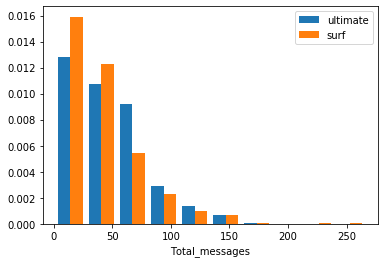

In [17]:
import matplotlib.pyplot as plt
plt.hist([ultimate_users['total_messages'],surf_users['total_messages']],label= ['ultimate','surf'], density = True)
plt.legend()
plt.xlabel('Total_messages')


I first just plotted the histograms but quickly realized that since Surf had more users in this sample, their bars were way higher than ultimate's. Therefore, I used density to get a relative understanding of how many users send a certain number of messages. Both plans seem to be having similar trends, and the graphs support the mean values we computed. Although Surf has higher values than Ultimate for fewer messages, they both have fewer customers who make more messages per month, decaying exponentially. The data is skewed to the right here.

Text(0.5, 0, 'Duration')

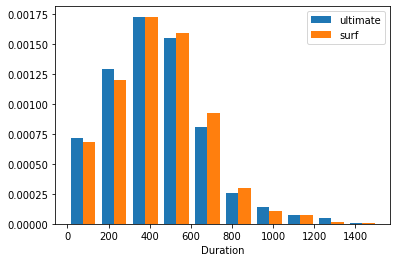

In [18]:
plt.hist([ultimate_users['duration'],surf_users['duration']],label= ['ultimate','surf'], density = True)
plt.legend()
plt.xlabel('Duration')

For duration of calls, overall, both plans have similar trends, but on local levels the gradient change is different with ultimate having more users who make shorter calls and surf having more users who make longer calls. The data is skewed to the right here and looks like a normal distribution with a mean around 430. 

Text(0.5, 0, 'Total_calls')

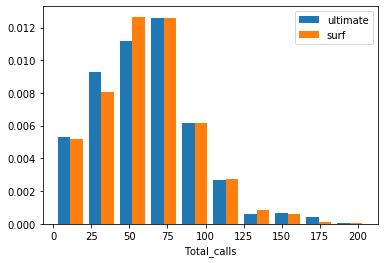

In [19]:
plt.hist([ultimate_users['calls'],surf_users['calls']],label= ['ultimate','surf'], density = True)
plt.legend()
plt.xlabel('Total_calls')

The data is skewed to the right here also. Total calls follows the similar trends that call duration also followed. The distribution is centered at 60.

Text(0.5, 0, 'mb_used')

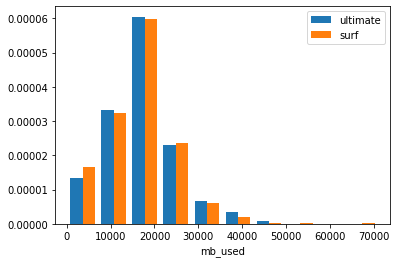

In [20]:
plt.hist([ultimate_users['mb_used'],surf_users['mb_used']],label= ['ultimate','surf'], density = True)
plt.legend()
plt.xlabel('mb_used')

The data is skewed to the right here also. There is a sharp centering around 20000 MB for users of both plans and there are very few users who use more or less than that becoming more less for more distance from the mean. This could be classified as a normal distribution too and probably has a good example of how the central limit theorem applies to real life.

# Sample hypothesis tests.

While we could ask many questions that this data could give us the answer to, let us focus on two questionsf for now. We will test the null hyopthesis that 'The average revenue from users of Ultimate and Surf calling plans does not differ' against the alternative hypothesis that 'The average revenue from users of Ultimate and Surf calling plans differs'. For this, we will use an alpha of 0.05, which means that only in 5% of cases will we reject the null hypothesis when it is true. We will consider the variances to be equal since all the calculations and graphs we showed above seem to suggest that. We will have to use a t test to test if there is a difference in the population means.


In [21]:
from scipy import stats as st
sample_surf = user_attributes.groupby(['plan'])['revenue'].get_group('surf')
sample_ultimate = user_attributes.groupby(['plan'])['revenue'].get_group('ultimate')
ultimate_mu = sample_ultimate.mean()
surf_mu = sample_surf.mean()
ultimate_sd = sample_ultimate.std()
surf_sd = sample_surf.std()
print('ultimate_mu', ultimate_mu)
print('surf_mu',surf_mu)
print('ultimate_sd', ultimate_sd)
print('surf_sd',surf_sd)
#display(sample_surf.head(20))

#user_attributes.head(20)

ultimate_mu 72.06313080202936
surf_mu 57.28641962394068
ultimate_sd 10.483267701556043
surf_sd 51.98648236622561


While there are big standard deviations, there is a very big difference in the average profit. My prediction is that the null hypothesis will be rejected.

In [22]:
alpha = 0.05 
# critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

#results = st.ttest_ind(sample_ultimate,sample_surf)


results = st.ttest_ind(user_attributes['monthly_profit_Surf'], user_attributes['monthly_profit_Ultimate'],nan_policy= 'omit')
#print(type(surf_users['monthly_profit']))
print('p-value:', results.pvalue)


if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")





p-value: 1.733590291064079e-11
We reject the null hypothesis


This is a very small p-value, implying that there is very strong evidence that there is a difference in the profit made by each company.

We will now test the null hyopthesis that 'The average profit from users in NY-NJ area is not different from that of the users from other regions'against the alternative hypothesis that 'The average profit from users in NY-NJ area is different from that of the users from other regions'. For this, we will use an alpha of 0.05, which means that only in 5% of cases will we reject the null hypothesis when it is true. We will consider the variances to be equal since all the calculations and graphs we showed above seem to suggest that. We will have to use a t test to test if there is a difference in the population means.

In [23]:
#ultimate_users['city'].value_counts()
user_attributes = pd.merge(user_attributes,cities,on='user_id')
users_NY_NJ = user_attributes.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')
users_not_NY_NJ = user_attributes.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')

users_NY_NJ_mu = users_NY_NJ['revenue'].mean()
users_not_NY_NJ_mu = users_not_NY_NJ['revenue'].mean()
users_NY_NJ_sd = users_NY_NJ['revenue'].std()
users_not_NY_NJ_sd = users_not_NY_NJ['revenue'].std()
print('users_NY_NJ_mu', users_NY_NJ_mu)
print('users_not_NY_NJ_mu',users_not_NY_NJ_mu)
print('users_NY_NJ_sd', users_NY_NJ_sd)
print('users_not_NY_NJ_sd',users_not_NY_NJ_sd)

users_NY_NJ_mu 55.63718764000896
users_not_NY_NJ_mu 63.378211175042225
users_NY_NJ_sd 37.761964759199614
users_not_NY_NJ_sd 44.465160155606355


In [24]:
alpha = .05 # critical statistical significance level
                        # if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        users_NY_NJ['revenue'], 
        users_not_NY_NJ['revenue'], nan_policy = 'omit')

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  0.0064317324164050605
We reject the null hypothesis


The p-value is tiny, giving us evidence to reject the null hypothesis. This means that users from the NY-NJ area, which are mostly metropolitan, give us much more profits than people from the rest of the country, which includes rural areas.

# Conclusions

Surf has a much lower base price but still manages to generate a decent revenue. This means that Surf has the potential to be more cheaper incase Megaline is trying to increase their market share.  

The study about the NY-NJ areas leads us to believe that Megaline should invest more in the urban areas since the profits are higher from areas that have more cities. 

Further analysis on the users age could have been done to figure out which is the most profitable demographic. Then, advertisement could be created to specifically target that group of people. For example, if ages 10-25 are the most profitable, then social media apps like Snapchat or Instagram would be a good place to advertise. 

As far as adjusting the rates for a call/text/data, we have some good insights into which is more profitable. We know that most users use around 20000 MB, so for a premeir plan, crossing that limit should have a heavier rate, and for a cheaper plan, the threshold should be lower than 20000 MB so that you have maximum number of people paying more.

Some users of the Surf Plan significantly overuse their plans while Ultimate users rarely overuse their plan. By understanding this, we could try to find high using Surf customers in the market and attract them with our plans for greater revenue.

The Ultimate plan produces more revenue than the Surf plan, but thanks to a few key user segments that drive the revenue much higher for the Surf plan. Therefore the Ultimate plan is more profitable.